# Proyecto 5 -análisis estadístico
## Análisis del precio de casas

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [170]:
df = pd.read_csv("train.csv")

## 1. Exploración y limpieza de la df

In [171]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [172]:
df.SaleCondition.value_counts() 
# para delimiar el estudio aún más filtraré la base eligiendo sólo las ventas que tuvieron una cond

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [173]:
#df=df[df.SaleCondition=='Normal']

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [175]:
# En principio resaltan las variables de alley, Fireplace, PoolQC, Fence, MiscFeature por el número de nulls
# Sin embargo es por el tipo de variables, que sean características que no todas las casas tienen:
#      - Alley: Type of alley access to property
#      - FireplaceQu: Fireplace quality
#      - PoolQC: Pool quality
#      - Fence: Fence quality
#      - MiscFeature: Miscellaneous feature not covered in other categories

### Conversión de variables

#### Variables dumies
Algunas variables de tipo categóricas serán convertidas en dummies:
- LandContour
- Utilities: Type of utilities available
- Neighborhood
- ExterCond: Evaluates the present condition of the material on the exterior
- HeatingQC: Heating quality and condition
- MiscFeature: Miscellaneous feature not covered in other categories

In [176]:
df_dummies=pd.get_dummies(df[['LandContour', 'Utilities', 'Neighborhood', 'ExterCond', 'HeatingQC', 'MiscFeature', 'Functional']])

### Correlación entre variable SalePrice y las variables de interés

Nuestra variable dependiente es SalePrice, así que es útil obtener la correlación entre esta y otras variables

In [177]:
cols = list(df)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

In [178]:
df=df.drop(labels='Id', axis=1)

In [179]:
# Para ver qué variables pueden servirnos por su relación con el precio hacemos una correlación
df.corr().loc[:'SalePrice'].T.sort_values('SalePrice', ascending=False).head(11)[1:8]

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664


In [180]:
df.corr().loc[:'SalePrice'].T.sort_values('SalePrice', ascending=False).tail(10)

,SalePrice
3SsnPorch,0.044584
BsmtFinSF2,-0.011378
BsmtHalfBath,-0.016844
MiscVal,-0.021190
LowQualFinSF,-0.025606
YrSold,-0.028923
OverallCond,-0.077856
MSSubClass,-0.084284
EnclosedPorch,-0.128578
KitchenAbvGr,-0.135907


In [181]:
# Parece que las variables con correlación positiva tienen un impacto más grande en el precio de las propiedades
# por lo que limitaré mi análisis las primeras 6, sin contar a la variable 'GarageCars'.

In [182]:
df_corr = df.corr().loc[:'SalePrice'].T.sort_values('SalePrice', ascending=False)[1:8]

In [183]:
cols.remove('GarageCars')

In [184]:
# limito mi df a as variables de interés
df_var= df[df_corr.index]
cols = list(df_var)
cols.remove('GarageCars')
#cols.append('Functional_categorical')
cols.append('SalePrice')
cols = [cols[-1]] + cols[:-1]
df_var = df[cols]

In [185]:
df_var = df_var[cols]

In [186]:
df_var = df_var.join(df_dummies)

## 2. Análisis de variables principales

In [187]:
import statsmodels.api as sm

Las variables elegidas para el modelo son las siguientes:
1. OverallQual: Rates the overall material and finish of the house
2. GrLivArea: Above grade (ground) living area square feet
3. TotalBsmtSF: Total square feet of basement area
4. 1stFlrSF: First Floor square feet
5. FullBath: Full bathrooms above grade

Y las variables dummies:
1. LandContour: Flatness of the property
2. Neighborhood: Physical locations within Ames city limits
3. ExterCond: Evaluates the present condition of the material on the exterior
4. MiscFeature: Miscellaneous feature not covered in other categories
5. Functional: Home functionality (Assume typical unless deductions are warranted)

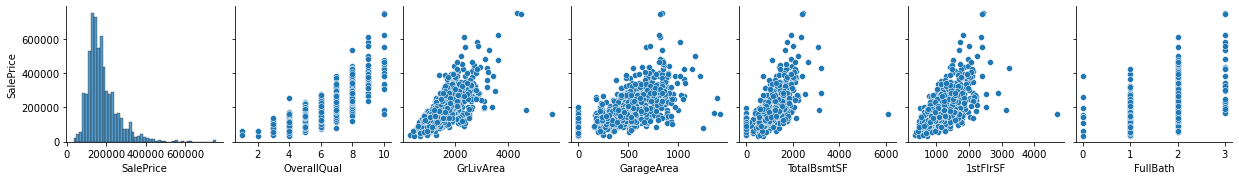

In [189]:
sns.pairplot(df_var, y_vars='SalePrice', x_vars=df_var.iloc[:,0:7])

### 1. Análisis de regresión lineal

In [190]:
X = df_var.dropna()
y = X.SalePrice
X = sm.add_constant(X.drop('SalePrice', axis=1))

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size=0.2)

In [192]:
lrm = LinearRegression().fit(X_train, y_train)

In [193]:
lrm.score(X_train, y_train)

0.8078882607384523

In [194]:
lrm.score(X_test, y_test)

0.8464104158618241

Parece que el modelo no está cayendo en overfitting o en underfitting.

### Interpretación del grado de explicación de las variables del modelo $Ordinary Least Squares$

In [195]:
sm.OLS(y, X.dropna()).fit()

In [196]:
lrm = sm.OLS(y, X.dropna()).fit()
lrm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     120.5
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:05:04   Log-Likelihood:                -17306.
No. Observations:                1460   AIC:                         3.472e+04
Df Residuals:                    1407   BIC:                         3.500e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.443e+04   9669.712     -3.560      0.000   -5.34e+04   -1.55e+04
OverallQual           1.573e+04   1180.778     13.325      0.000    1.34e+04     1.8e+04
GrLivArea               47.3212      3.009     15.728      0.000      41.419      53.223
GarageArea              35.6109      5.851      6.086      0.000      24.132      47.090
TotalBsmtSF             12.3692      4.021      3.076      0.002       4.482      20.256
1stFlrSF                17.0376      4.925      3.460      0.001       7.377      26.698
FullBath             -1862.7399   2557.284     -0.728      0.466   -6879.240    3153.761
LandContour_Bnk      -2.863e+04   4771.178     -6.000      0.000    -3.8e+04   -1.93e+04
LandContour_HLS       1964.9316   5149.630      0.382      0.703   -8136.847    1.21e+04
LandContour_Low       4588.5439   5694.751      0.806      0.421   -6582.573    1.58e+04
LandContour_Lvl      -1.235e+04   3303.855     -3.738      0.000   -1.88e+04   -5870.328
Utilities_AllPub      7955.5701   1.42e+04      0.559      0.576      -2e+04    3.59e+04
Utilities_NoSeWa     -4.238e+04   2.16e+04     -1.960      0.050   -8.48e+04      43.600
Neighborhood_Blmngtn -1.519e+04   8500.811     -1.786      0.074   -3.19e+04    1490.621
Neighborhood_Blueste -2.196e+04   2.37e+04     -0.926      0.354   -6.85e+04    2.45e+04
Neighborhood_BrDale  -2.837e+04   8737.977     -3.247      0.001   -4.55e+04   -1.12e+04
Neighborhood_BrkSide -1.049e+04   4896.480     -2.143      0.032   -2.01e+04    -889.171
Neighborhood_ClearCr  9755.5316   7148.115      1.365      0.173   -4266.579    2.38e+04
Neighborhood_CollgCr -1002.0113   3399.846     -0.295      0.768   -7671.323    5667.301
Neighborhood_Crawfor  1.086e+04   5213.559      2.082      0.037     629.022    2.11e+04
Neighborhood_Edwards -2.084e+04   3924.497     -5.310      0.000   -2.85e+04   -1.31e+04
Neighborhood_Gilbert  -414.8263   4350.953     -0.095      0.924   -8949.880    8120.228
Neighborhood_IDOTRR  -2.594e+04   6111.012     -4.245      0.000   -3.79e+04    -1.4e+04
Neighborhood_MeadowV -1.559e+04   8465.972     -1.842      0.066   -3.22e+04    1015.827
Neighborhood_Mitchel  -1.29e+04   5098.833     -2.531      0.011   -2.29e+04   -2901.548
Neighborhood_NAmes   -1.276e+04   3031.286     -4.211      0.000   -1.87e+04   -6818.464
Neighborhood_NPkVill -1.488e+04   1.14e+04     -1.303      0.193   -3.73e+04    7530.405
Neighborhood_NWAmes  -1.147e+04   4407.835     -2.603      0.009   -2.01e+04   -2826.015
Neighborhood_NoRidge  5.152e+04   5965.731      8.636      0.000    3.98e+04    6.32e+04
Neighborhood_NridgHt  5.169e+04   4887.016     10.578      0.000    4.21e+04    6.13e+04
Neighborhood_OldTown -3.094e+04   3769.665     -8.209      0.000   -3.83e+04   -2.35e+04
Neighborhood_SWISU    -2.36e+04   7309.789     -3.228    

In [197]:
predicted = lrm.predict(X_test)
print(f'La media del error absoluto es: {metrics.mean_absolute_error(y_test, predicted)}')

La media del error absoluto es: 19780.432020561762


De acuerdo a la R<sup>2</sup> las variables utilizadas en nuestro modelo explican el 81.8% de la variación en precio. Dado que la R<sup>2adj</sup> está muy cerca de la R<sup>2</sup> parece ser que no hay penalización por variables que no estén aportando a nuestro resultado. El valor 0 del F-statistic señala la probabilidad de que el efecto de las variables del modelo sobre la variable elegida sea 0.

Los altos valores de P>|t| de las variables de Heating, MiscFeature, ExterCond, Functional y Neighborhood sugieren que estas no aportan al modelo por lo que podrían ser removidas para simplificarlo.


In [198]:
df_var_b = df[df_corr.index]
cols = list(df_var_b)
cols.remove('GarageCars')
cols.append('SalePrice')
cols = [cols[-1]] + cols[:-1]
df_var_b = df[cols]

In [199]:
df_dummies_b = pd.get_dummies(df[['LandContour', 'Utilities', 'HeatingQC']])

In [200]:
df_var_b=df_var_b.join(df_dummies_b)

In [201]:
X = df_var_b.dropna()
y = X.SalePrice
X = sm.add_constant(X.drop('SalePrice', axis=1))
sm.OLS(y, X.dropna()).fit()
lrm = sm.OLS(y, X.dropna()).fit()
lrm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     348.6
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:05:05   Log-Likelihood:                -17466.
No. Observations:                1460   AIC:                         3.496e+04
Df Residuals:                    1445   BIC:                         3.504e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5.305e+04    1.1e+04     -4.832      0.000   -7.46e+04   -3.15e+04
OverallQual       2.289e+04   1118.814     20.462      0.000    2.07e+04    2.51e+04
GrLivArea           44.4796      2.923     15.215      0.000      38.745      50.214
GarageArea          50.4310      6.042      8.346      0.000      38.578      62.284
TotalBsmtSF         19.4501      4.275      4.550      0.000      11.065      27.835
1stFlrSF            14.6049      4.979      2.933      0.003       4.838      24.372
FullBath           714.2958   2488.031      0.287      0.774   -4166.243    5594.834
LandContour_Bnk  -4.001e+04   5051.950     -7.920      0.000   -4.99e+04   -3.01e+04
LandContour_HLS    573.7855   5434.711      0.106      0.916   -1.01e+04    1.12e+04
LandContour_Low   5833.9635   5918.345      0.986      0.324   -5775.505    1.74e+04
LandContour_Lvl  -1.944e+04   3522.973     -5.519      0.000   -2.64e+04   -1.25e+04
Utilities_AllPub -1.232e+04   1.44e+04     -0.854      0.393   -4.06e+04     1.6e+04
Utilities_NoSeWa -4.073e+04   2.42e+04     -1.683      0.093   -8.82e+04    6754.309
HeatingQC_Ex      2513.1501   7467.244      0.337      0.737   -1.21e+04    1.72e+04
HeatingQC_Fa     -1.114e+04   8460.562     -1.317      0.188   -2.77e+04    5451.527
HeatingQC_Gd     -9172.1442   7479.523     -1.226      0.220   -2.38e+04    5499.740
HeatingQC_Po     -2.297e+04   3.14e+04     -0.731      0.465   -8.46e+04    3.86e+04
HeatingQC_TA     -1.227e+04   7397.664     -1.659      0.097   -2.68e+04    2239.993
==============================================================================
Omnibus:                      441.770   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45225.517
Skew:                          -0.308   Prob(JB):                         0.00
Kurtosis:                      30.259   Cond. No.                     3.04e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.61e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [204]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, random_state = 22, test_size=0.2)

In [206]:
predicted = lrm.predict(X_test_b)

In [208]:
predicted = lrm.predict(X_test_b)
print(f'La media del error absoluto del modelo b es: {metrics.mean_absolute_error(y_test, predicted)}')

La media del error absoluto del modelo b es: 22966.46547708684


Aunque al retirar las variables antes descritas se logra un modelo más simple, el grado de predictibilidad del modelo cayó cerca del 4%. Sin embargo la media del error absoluto es más grande en el modelo b. La elección del modelo final dependerá de la disponibilidad de la información, pero el modelo a es más certero.